In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib

Using TensorFlow backend.
C:\Users\Gabriel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Gabriel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Gabriel\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Gabriel\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [54]:
"""
Specify rep choice: <'narrowband', 'broadband', 'wvlt', 'early_fuse2/3', 'late_fuse2/3', 'mc_fuse'>
mc_fuse: multi-channel fusion
fuse2/3: 2 utilized only narrowband/broadband, 3 included wvlt
"""

PATH=os.getcwd()

mod="CAE"
rep='narrowband'

if rep in ['narrowband', 'broadband', 'wvlt']:
    res_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_'+rep+'_aggResults.pkl'
    aggResults=pd.read_pickle(res_path)
    
if rep=='mc_fuse':
    res_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_mcFusionResults.pkl'
    aggResults=pd.read_pickle(res_path)
    rep='multi-channel fusion - narrowband/broadband'

if rep=='early_fuse2':
    res_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_earlyFusionResults.pkl'
    aggResults=pd.read_pickle(res_path)
    rep='early fusion - narrowband/broadband'

if rep=='late_fuse2':
    res_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_lateFusionResults.pkl'
    aggResults=pd.read_pickle(res_path)
    rep='late fusion - narrowband/broadband'

if rep=='early_fuse3':
    res_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_wvlt_earlyFusionResults.pkl'
    aggResults=pd.read_pickle(res_path)
    rep='early fusion - narrowband/broadband/wvlt'

if rep=='late_fuse3':
    res_path=PATH+"/pdSpanish/classResults/svm/"+mod+'_wvlt_lateFusionResults.pkl'
    aggResults=pd.read_pickle(res_path)
    rep='late fusion - narrowband/broadband/wvlt'
    
mfda_path=PATH+"/pdSpanish/"
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
pd_mfdas=mfdas[0:50]
hc_mfdas=mfdas[50:]

In [55]:
num_spks=100
num_itrs=max(aggResults['Data']['bin_class'].keys())+1
num_itrs=1

sdAggResults=np.zeros((num_spks,num_itrs,aggResults['Data']['bin_class'][0][0].shape[0],aggResults['Data']['bin_class'][0][0].shape[1]))
avgAggResults={spk:{num[i]:[] for num in zip(range(num_spks//2),range(num_spks//2,num_spks))} for i,spk in enumerate(['pd','hc'])}
mfdaResults=np.zeros(num_spks)

for j in range(num_itrs):
    for i in range(num_spks):
        sdAggResults[i,j,:,:]=aggResults['Data']['bin_class'][j][i]
        
        if j==0:
#             if num_itrs==1:
#                 mfdaResults[i]=aggResults['Data']['mFDA_spear_corr'][j][i][0]*(1/num_itrs)
#             else:
#                 mfdaResults[i]=np.median(list(aggResults['Data']['mFDA_spear_corr'][j][i].values()))*(1/num_itrs)
            if i<num_spks//2:
                avgAggResults['pd'][i]=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
            else:
                avgAggResults['hc'][i]=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
        else:
#             if rep!='late fusion - narrowband/broadband/wvlt':
#             if num_itrs==1:
#                 mfdaResults[i]+=aggResults['Data']['mFDA_spear_corr'][j][i][0]*(1/num_itrs)
#             else:
#                 mfdaResults[i]+=np.median(list(aggResults['Data']['mFDA_spear_corr'][j][i].values()))*(1/num_itrs)
            if i<num_spks//2:
                avgAggResults['pd'][i]+=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)
            else:
                avgAggResults['hc'][i]+=aggResults['Data']['bin_class'][j][i]*(1/num_itrs)

In [56]:
test_acc=0
y_score=np.zeros((100,2))
y_score_curr=y_score
y_test=np.zeros((100,2))
y_test_curr=y_test
max_acc=0
thresh=0
for i in range(100):
    if i<50:
        y_score[i,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
        y_test[i,:]=np.vstack((np.zeros(1),np.ones(1))).T
        spk_diff=y_score[i,1]-y_score[i,0]
        if spk_diff>thresh:
            test_acc+=1
    else:
        y_score[i,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
        y_test[i,:]=np.vstack((np.ones(1),np.zeros(1))).T
        spk_diff=y_score[i,1]-y_score[i,0]
        if spk_diff<thresh:
            test_acc+=1
        

Text(0.5, 1.0, 'SVM Classifier\nm-FDA v. Difference in Classification Probability\nCAE, narrowband\nOverall Test Acc: 0.71\n$\\rho$ = 0.489\nPrecision: 0.712 Recall: 0.71')

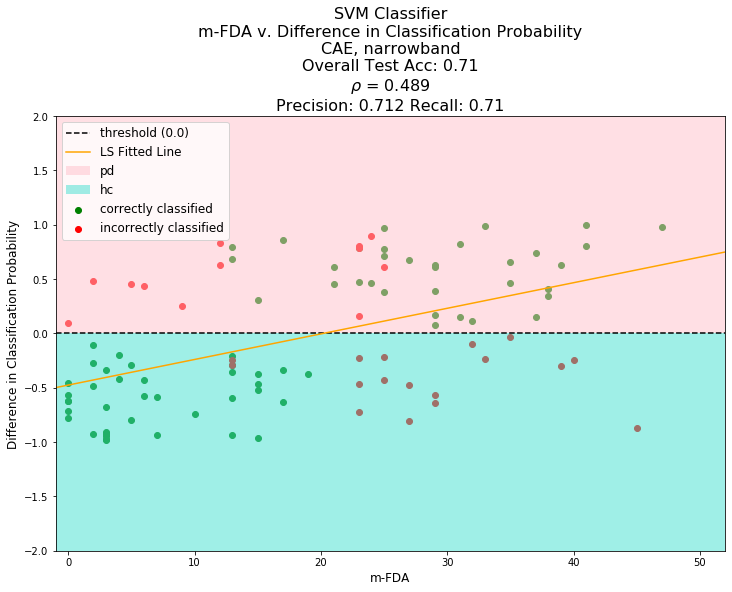

In [57]:
"""Prediction based on difference between predicted class probs."""
plt.figure(figsize=(12,8))
poly=np.polyfit(mfdas, y_score[:,1]-y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(mfdas, y_score[:,1]-y_score[:,0])
precision=precision_score(np.concatenate((np.ones(50),np.zeros(50))), np.ceil(y_score[:,1]-y_score[:,0]), average='macro')
recall=recall_score(np.concatenate((np.ones(50),np.zeros(50))), np.ceil(y_score[:,1]-y_score[:,0]), average='macro')

correct_idx=np.concatenate((np.where((y_score[0:50,1]-y_score[0:50,0])>0)[0],np.where((y_score[50:,1]-y_score[50:,0])<0)[0]+50))
incorrect_idx=np.concatenate((np.where((y_score[0:50,1]-y_score[0:50,0])<0)[0],np.where((y_score[50:,1]-y_score[50:,0])>0)[0]+50))
plt.scatter(mfdas[correct_idx],(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
plt.scatter(mfdas[incorrect_idx],(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(float(thresh))+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'],fontsize=12)
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA',fontsize=12)
plt.ylabel('Difference in Classification Probability',fontsize=12)
plt.title('SVM Classifier\nm-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/100)+'\n'+r'$\rho$'+ " = "
          +str(np.round(cor[0],3))+"\nPrecision: "+str(np.round(precision,3))+" Recall: "+str(np.round(recall,3)), fontsize=16)

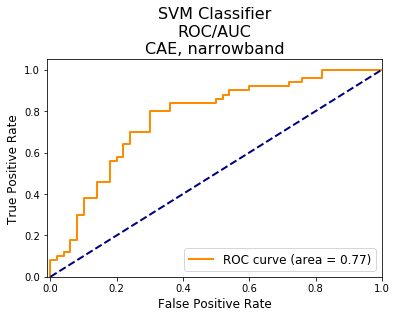

In [58]:
"""Looking at the ROC for a given classifier for a given patient and corresponding AUC."""
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]), np.array(y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('SVM Classifier\nROC/AUC\n'+mod+", "+rep, fontsize=16)
plt.legend(loc="lower right",fontsize=12)

In [52]:
# """Takes standard deviation across multiple iterations of classification probabilites and then averaged over each utterance"""
# spk_avg_var=np.zeros(100)
# for i in range(100):
#     spk_avg_var[i]=np.mean(np.std(sdAggResults[i],axis=0))
        
# mean_var=np.mean(spk_avg_var)
        
# plt.scatter(mfdas,spk_avg_var)
# plt.xlim([-1,50])
# plt.ylim([-.001,1])
# plt.xlabel('m-FDA',fontsize=12)
# plt.ylabel('Std. of Prediction per Speaker',fontsize=12)
# plt.title('SVM Classifier\nStd. of Prediction per Speaker vs. Speaker m-FDA (Over '+str(num_itrs)+' Iterations)\n'+mod+", "+rep+"\nAvg. Std. Over "+str(num_itrs)+" Iterations: "+ str(np.round(mean_var,3)), fontsize=16)

Text(0.5, 1.0, 'SVM Classifier\nm-FDA v. Difference in Classification Probability for 20th percentile "extreme" cases\n(m-FDAs <= 2 and >= 37)\nCAE, multi-channel fusion - narrowband/broadband\nOverall Test Acc: 0.95\n$\\rho$ = 0.899')

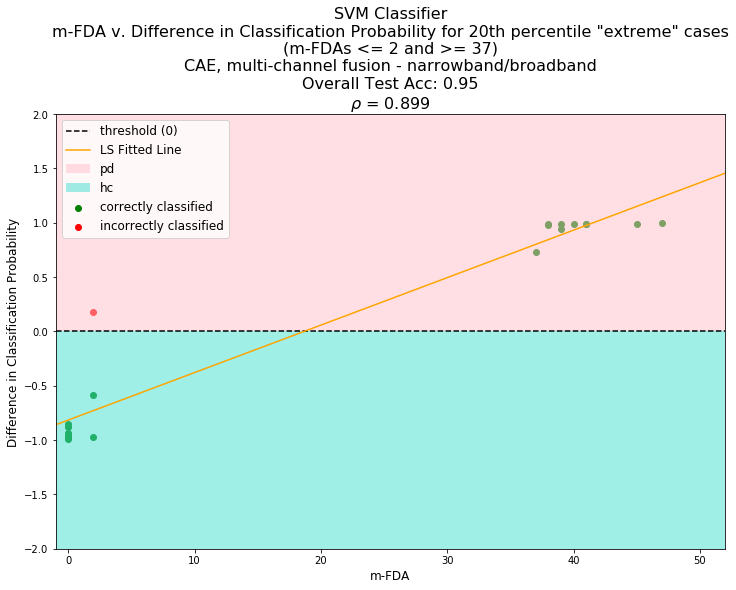

In [53]:
"""Looking at 2*n most 'extreme' cases in the database (n patients with smallest and n patients with largest m-fdas)"""

n=10

df=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
tail10_idx=np.sort(np.concatenate((df.nsmallest(n,['M-FDA']).index,df.nlargest(n,['M-FDA']).index)))
max_low=max(list(df['M-FDA'].nsmallest(n)))
min_high=min(list(df['M-FDA'].nlargest(n)))
xtr_mfdas=mfdas[tail10_idx]
xtr_y_score=y_score[tail10_idx,:]
xtr_y_test=y_test[tail10_idx,:]


"""Prediction based on difference between predicted class probs."""
plt.figure(figsize=(12,8))
poly=np.polyfit(xtr_mfdas, xtr_y_score[:,1]-xtr_y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(xtr_mfdas, xtr_y_score[:,1]-xtr_y_score[:,0])

correct_idx=np.concatenate((np.where((xtr_y_score[0:n,0]-xtr_y_score[0:n,1])<0)[0],np.where((xtr_y_score[n:,0]-xtr_y_score[n:,1])>0)[0]+n))
incorrect_idx=np.concatenate((np.where((xtr_y_score[0:n,0]-xtr_y_score[0:n,1])>0)[0],np.where((xtr_y_score[n:,0]-xtr_y_score[n:,1])<0)[0]+n))
plt.scatter(xtr_mfdas[correct_idx],(xtr_y_score[:,1]-xtr_y_score[:,0])[correct_idx],c='g' )
plt.scatter(xtr_mfdas[incorrect_idx],(xtr_y_score[:,1]-xtr_y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'],fontsize=12)
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA',fontsize=12)
plt.ylabel('Difference in Classification Probability',fontsize=12)
plt.title('SVM Classifier\nm-FDA v. Difference in Classification Probability for '+str(2*n)+'th percentile "extreme" cases\n(m-FDAs <= '+str(max_low)+' and >= '+str(min_high)+')\n'+mod+", "+rep+'\nOverall Test Acc: '+
          str(correct_idx.shape[0]/(2*n))+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)), fontsize=16)



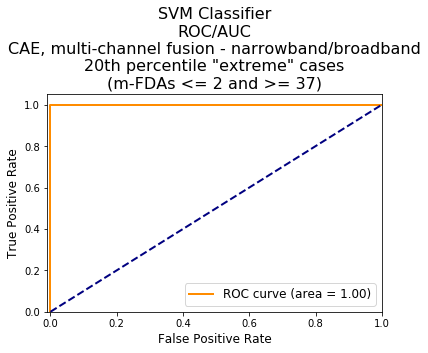

In [171]:
"""
Looking at the ROC for a given classifier for a given patient and corresponding AUC.
Specifically, looking at 2*n most 'extreme' cases in the database (n patients with smallest and n patients with largest m-fdas)

"""
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(xtr_y_test[:, i]), np.array(xtr_y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('SVM Classifier\nROC/AUC\n'+mod+", "+rep+'\n'+str(2*n)+'th percentile "extreme" cases\n(m-FDAs <= '+str(max_low)+
          ' and >= '+str(min_high)+')', fontsize=16)
plt.legend(loc="lower right",fontsize=12)

Text(0.5, 1.0, 'SVM Classifier\nm-FDA v. Difference in Classification Probability for Middle 80th Percentile of m-FDAs\n(m-FDAs > 2 and < 37)\nCAE, multi-channel fusion - narrowband/broadband\nOverall Test Acc: 0.925\n$\\rho$ = 0.737')

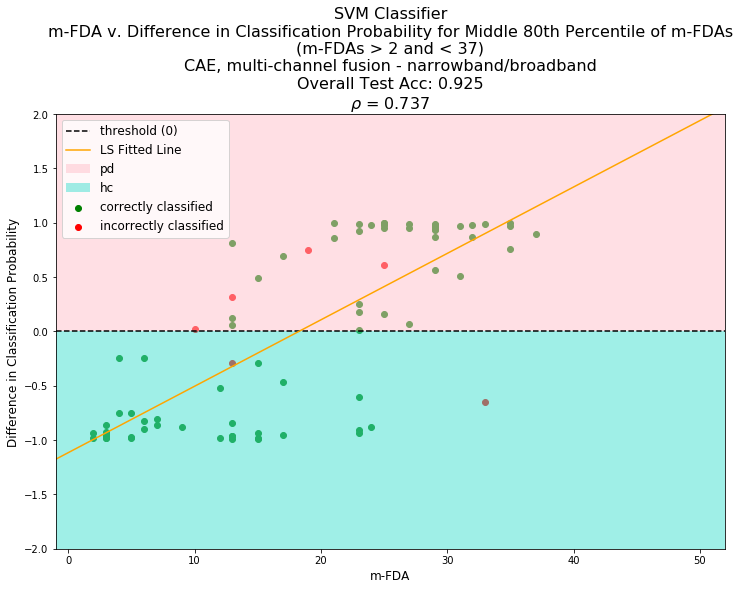

In [50]:
"""Looking at results for spks corresponding to middle num_spks-2*n m-FDAs."""

n=10

df=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
tail10_idx=np.sort(np.concatenate((df.nsmallest(n,['M-FDA']).index,df.nlargest(n,['M-FDA']).index)))
mid_idxs=np.array([idx for idx in np.arange(100) if idx not in tail10_idx])
max_low=max(list(df['M-FDA'].nsmallest(n)))
min_high=min(list(df['M-FDA'].nlargest(n)))
mid_mfdas=mfdas[mid_idxs]
mid_y_score=y_score[mid_idxs,:]
mid_y_test=y_test[mid_idxs,:]


"""Prediction based on difference between predicted class probs."""
plt.figure(figsize=(12,8))
poly=np.polyfit(mid_mfdas, mid_y_score[:,1]-mid_y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(mid_mfdas, mid_y_score[:,1]-mid_y_score[:,0])

correct_idx=np.concatenate((np.where((mid_y_score[0:40,1]-mid_y_score[0:40,0])>0)[0],np.where((mid_y_score[40:,1]-mid_y_score[40:,0])<0)[0]+40))
incorrect_idx=np.concatenate((np.where((mid_y_score[0:40,1]-mid_y_score[0:40,0])<0)[0],np.where((mid_y_score[40:,1]-mid_y_score[40:,0])>0)[0]+40))
plt.scatter(mid_mfdas[correct_idx],(mid_y_score[:,1]-mid_y_score[:,0])[correct_idx],c='g' )
plt.scatter(mid_mfdas[incorrect_idx],(mid_y_score[:,1]-mid_y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="optimal threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'],fontsize=12)
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA',fontsize=12)
plt.ylabel('Difference in Classification Probability',fontsize=12)
plt.title('SVM Classifier\nm-FDA v. Difference in Classification Probability for Middle '+str(100-2*n)+'th Percentile of m-FDAs\n(m-FDAs > '+str(max_low)+' and < '+str(min_high)+')\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/(100-2*n))+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)), fontsize=16)

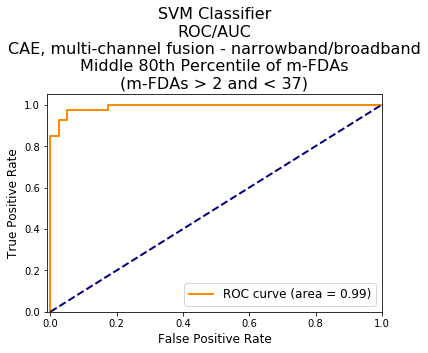

In [173]:
"""
Looking at the ROC for a given classifier for a given patient and corresponding AUC.
Specifically, looking at spks corresponding to middle num_spks-2*n m-FDAs.

"""
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(mid_y_test[:, i]), np.array(mid_y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('SVM Classifier\nROC/AUC\n'+mod+", "+rep+'\nMiddle '+str(100-2*n)+'th Percentile of m-FDAs\n(m-FDAs > '+str(max_low)+' and < '+str(min_high)+')', fontsize=16)
plt.legend(loc="lower right",fontsize=12)

One sided T-test to determine if difference in M/F results is significant.
Null Hypothesis: mean difference in probability output by the classifier for M/F speakers
 is not significant.

M/F actual m-FDAS [T-test stat: 0.627, p-value: 0.532]
M/F difference in probabilities [T-test stat: 0.93738, p-value: 0.34894]


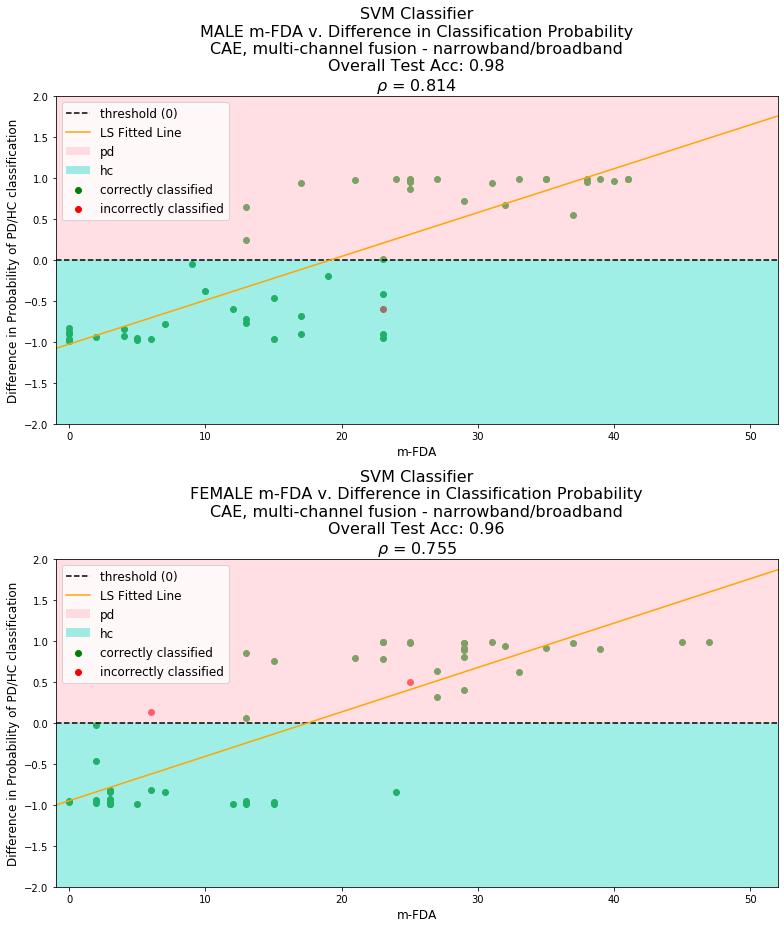

In [174]:
"""Gender based classification results (note that data used to train AEs skewed heavily male while PD data is evenly split M/F)"""
num_spks=100
mfda_path=PATH+"/pdSpanish/"
data=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
genders=data['gender'].values
mfdas=data['M-FDA'].values
m_idx=np.where(genders=='M')[0]
f_idx=np.where(genders=='F')[0]
m_mfdas=mfdas[m_idx]
f_mfdas=mfdas[f_idx]

m_test_acc=0
f_test_acc=0
m_y_score=np.zeros((50,2))
m_y_test=np.zeros((50,2))
f_y_score=np.zeros((50,2))
f_y_test=np.zeros((50,2))
m_res=np.zeros(300)
f_res=np.zeros(300)

m_count=0
f_count=0
for i in range(100):
        
    if i<50:
        if i in m_idx:
            m_res[6*m_count:(m_count+1)*6]= avgAggResults['pd'][i][:,0]
            m_y_score[m_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff>thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_res[6*f_count:(f_count+1)*6]= avgAggResults['pd'][i][:,0]
            f_y_score[f_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff>thresh:
                f_test_acc+=1
            f_count+=1
    else:
        if i in m_idx:
            m_res[6*m_count:(m_count+1)*6]= avgAggResults['hc'][i][:,0]
            m_y_score[m_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff<thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_res[6*f_count:(f_count+1)*6]= avgAggResults['hc'][i][:,0]
            f_y_score[f_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff<thresh:
                f_test_acc+=1
            f_count+=1


"""Prediction based on difference between predicted class probs."""

itr=0

print('One sided T-test to determine if difference in M/F results'+
      ' is significant.\nNull Hypothesis: mean difference in probability output by the classifier for M/F speakers'+
      '\n is not significant.\n\nM/F actual m-FDAS [T-test stat: '+
      str(np.round(np.abs(stats.ttest_ind(m_mfdas,f_mfdas).statistic),3))+
      ', p-value: '+str(np.round(np.abs(stats.ttest_ind(m_mfdas,f_mfdas).pvalue),3))+
      ']\nM/F difference in probabilities [T-test stat: '+
      str(np.round(np.abs(stats.ttest_ind(m_res,f_res).statistic),5))+
      ', p-value: '+str(np.round(np.abs(stats.ttest_ind(m_res,f_res).pvalue),5))+']')

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(11,13))
for ax,mfdas,y_score,y_test in zip([ax1,ax2],[m_mfdas,f_mfdas],[m_y_score,f_y_score],[m_y_test,f_y_test]):
    poly=np.polyfit(mfdas, y_score[:,1]-y_score[:,0], 1)
    x_lin_reg = range(-2, 53)
    predict = np.poly1d(poly)
    cor=stats.spearmanr(mfdas, y_score[:,1]-y_score[:,0])
    
    correct_idx=np.concatenate((np.where((y_score[0:25,0]-y_score[0:25,1])<0)[0],np.where((y_score[25:,0]-y_score[25:,1])>0)[0]+25))
    incorrect_idx=np.concatenate((np.where((y_score[0:25,0]-y_score[0:25,1])>0)[0],np.where((y_score[25:,0]-y_score[25:,1])<0)[0]+25))
    ax.scatter(mfdas[correct_idx],(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
    ax.scatter(mfdas[incorrect_idx],(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
    ax.axhline(y=thresh, color='black', linestyle='--',label="threshold")
    ax.plot(x_lin_reg,predict(x_lin_reg), color='orange')
    ax.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
    ax.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
    ax.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'], fontsize=12)
    ax.set_xlim([-1,52])
    ax.set_ylim([-2,2])
    ax.set_xlabel('m-FDA', fontsize=12)
    ax.set_ylabel('Difference in Probability of PD/HC classification', fontsize=12)
    if itr==0:
        ax.set_title('SVM Classifier\nMALE m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+
                     str(correct_idx.shape[0]/50)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)), fontsize=16)
        itr+=1
    else:
        ax.set_title('SVM Classifier\nFEMALE m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+
                     str(correct_idx.shape[0]/50)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)), fontsize=16)
plt.tight_layout()




In [175]:
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
cor=np.round(stats.spearmanr(mfdas,mfdaResults),3)[0]
up_lims=np.histogram(mfdas,bins=3)[1][1:]
pred_up_lims=np.histogram(mfdaResults,bins=3)[1][1:]

In [176]:
"""
Here we cluster the m-FDA scores (using KMeans clustering) into nc groups to see how the classifier and representation 
choice performs in prediciting the severity of the disease. The Spearman correlation is also reported in the figure title
and considers the actual m-FDAs and predicted m-FDAs (not clustered groups).
"""
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
cor=np.round(stats.spearmanr(mfdas,mfdaResults),3)[0]
up_lims=np.histogram(mfdas,bins=3)[1][1:]
pred_up_lims=np.histogram(mfdaResults,bins=3)[1][1:]

mfdas[np.where(mfdas<up_lims[0])]=0
mfdas[np.where(mfdas>up_lims[1])]=2
mfdas[np.where(mfdas>2)]=1
mfdaResults[np.where(mfdas<pred_up_lims[0])]=0
mfdaResults[np.where(mfdas>pred_up_lims[1])]=2
mfdaResults[np.where(mfdas>2)]=1

cm = confusion_matrix(y_pred,y_act)
sns.heatmap(cm, annot=True, cmap='YlOrRd', cbar = True, xticklabels = np.arange(0,ncs), yticklabels = np.arange(0,ncs), cbar_kws={'label': 'Number of Patients'})
plt.title("Confusion Matrix - Clustered m-FDA Values\n SVM Classifier\n Actual m-FDAs v. Predicted m-FDAs: " +r'$\rho$'+ "="+str(cor), fontsize=16)
plt.xlabel("Predicted",fontsize=12)
plt.ylabel("Actual",fontsize=12)


NameError: name 'y_pred' is not defined